In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up Network

In [3]:
## Parameters

## task type
# task_type='Iris_classification'
task_type='Regression'

## task matrix X
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])

## specify # of nodes
Nin: int = 2
extraNin: int = 0
Ninter: int = 0
Nout: int = 2
extraNout: int = 0

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.5  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
# R_update: str = 'R_propto_dp'
R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 1.9, 1., 1.85, 1.05, 1.9, 1., 0.85])
# R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]

# length of training dataset
iterations = 2400  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 30

# noise_to_extra: bool = True  # add noise to extra outputs 
noise_to_extra: bool = False  # add noise to extra outputs 

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 1.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False
# access_interNodes: bool = True  # access and change pressure at interNodes (nodes between input and output) or not
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
# stay_sample: int = 2  # how many loop iterations to stay under the same sampled p
stay_sample: int = 2

## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         extraNin, \
                         Nout, \
                         extraNout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         Ninter, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)
Variabs.create_noise_for_extras()

alpha_vec [0.5 0.5]
input M mismatches output and input
no extra input nodes, no noise added
no extra output nodes, no noise added


In [5]:
## Assign input and output nodes a.f.o lattice size and row choice
inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs. extraNin, Variabs.Ninter, 
                                                                        Variabs.Nout, Variabs.extraNout)

In [6]:
print('input_nodes_arr ', inInterOutGround_tuple[0])
print('extraInput_nodes_arr ', inInterOutGround_tuple[1])
print('inter_nodes_arr ', inInterOutGround_tuple[2])
print('output_nodes_arr ', inInterOutGround_tuple[3])
print('extraOutput_nodes_arr ', inInterOutGround_tuple[4])
print('ground_nodes_arr ', inInterOutGround_tuple[5])

input_nodes_arr  [0 1]
extraInput_nodes_arr  []
inter_nodes_arr  []
output_nodes_arr  [2 3]
extraOutput_nodes_arr  []
ground_nodes_arr  [4]


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(inInterOutGround_tuple)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

if access_interNodes:
    State = Network_State(Variabs, Ninter)
else:
    State = Network_State(Variabs)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

R_vec_i has wrong size, initializing all ones


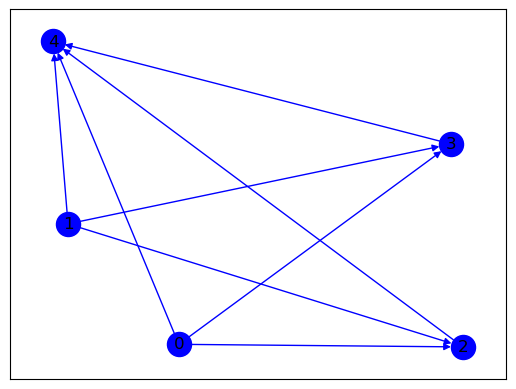

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

In [11]:
Strctr.EIEJ_plots

[(0, 2), (0, 3), (1, 2), (1, 3), (0, 4), (1, 4), (2, 4), (3, 4)]

## Train

In [12]:
for i in range(Variabs.iterations):
    print('i', i)
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % iterations == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)

    # staying stay_sample iteration under same sample
    if use_p_tag and noise_to_extra:
        k = (i//(2*stay_sample))
    elif use_p_tag and not(noise_to_extra):
        k = (i//stay_sample)*2 + i%2
    elif not(use_p_tag) and noise_to_extra:
        k = (i//stay_sample)
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    if i % 2:
        State.draw_p_in_and_desired(Variabs, k, noise_to_extra=noise_to_extra)  # add noise to extra nodes every 2nd iteration
        State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=noise_to_extra)  # measure and don't change resistances
    else:  # dont add noise to extra nodes
        State.draw_p_in_and_desired(Variabs, k)
        State.solve_flow_given_problem(BigClass, "measure")    
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.t += 1
        print('time=', State.t)
        State.calc_loss(BigClass)
        State.update_input_dual(BigClass)
        # State.update_extraInput_dual(BigClass)
        State.update_output_dual(BigClass)
        State.update_extraOutput_dual(BigClass)
        if access_interNodes:
            State.update_inter_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t):
        State.calculate_accuracy_fullDataset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

i 0
k 0
input_drawn [0.74908024 1.90142861]
desired output= [0.49264776 0.37741292]
output measured= [0.88350295 0.88350295]
extraOutput measured= []
i 1
k 1
input_drawn [1.46398788 1.19731697]
desired output= [0.45906158 0.48572867]
extraOutput []
output measured= [0.88710162 0.88710162]
extraOutput measured= []
time= 1
loss= [[-0.42804004 -0.40137295]
 [-0.39085519 -0.50609003]]
input_dual_nxt= [-0.02413965  0.02377512]
output_dual_nxt [-6.69079479e-05  1.88420959e-04]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 2
k 2
input_drawn [0.31203728 0.31198904]
desired output= [0.1092034  0.10920822]
output measured= [0.20805233 0.20808775]
extraOutput measured= []
i 3
k 3
input_drawn [0.11616722 1.73235229]
desired output= [0.36389554 0.20227704]
extraOutput []
output measured= [0.60339037 0.60348979]
extraOutput measured= []
time= 2
loss= [[-0.23949483 -0.40121276]
 [-0.09884893 -0.09887953]]
input_dual_nxt= [-0.04338317  0.31459564]
outpu

output measured= [0.29443547 0.33724056]
extraOutput measured= []
time= 60
loss= [[-0.02994951  0.02091772]
 [-0.01842812  0.0163681 ]]
input_dual_nxt= [0.0025426  0.00106525]
output_dual_nxt [-0.00104873  0.00047398]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 120
k 120
input_drawn [1.88091717 1.90785715]
desired output= [0.66370901 0.66101501]
output measured= [0.63486625 0.72647898]
extraOutput measured= []
i 121
k 121
input_drawn [1.82972878 0.7403174 ]
desired output= [0.4225228  0.53146394]
extraOutput []
output measured= [0.45183626 0.5181632 ]
extraOutput measured= []
time= 61
loss= [[-0.02931346  0.01330073]
 [ 0.02884275 -0.06546397]]
input_dual_nxt= [0.00052746 0.01203062]
output_dual_nxt [ 0.00532217 -0.00820397]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 122
k 122
input_drawn [0.03091323 1.85663713]
desired output= [0.37596441 0.19339202]
output measured= [0.28253007 0.31

i 248
k 248
input_drawn [1.16731222 0.15546927]
desired output= [0.20619069 0.30737498]
output measured= [0.24259267 0.27099462]
extraOutput measured= []
i 249
k 249
input_drawn [1.94878962 1.97242149]
desired output= [0.68680274 0.68443955]
extraOutput []
output measured= [0.64989899 0.72355499]
extraOutput measured= []
time= 125
loss= [[ 0.03690375 -0.03911544]
 [-0.03640198  0.03638037]]
input_dual_nxt= [0.00085575 0.00198963]
output_dual_nxt [ 0.01492894 -0.0170832 ]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 250
k 250
input_drawn [1.39632343 1.07219273]
desired output= [0.42388706 0.45630013]
output measured= [0.42492542 0.45527796]
extraOutput measured= []
i 251
k 251
input_drawn [0.61905523 1.62759004]
desired output= [0.41837629 0.31752281]
extraOutput []
output measured= [0.35610296 0.38082748]
extraOutput measured= []
time= 126
loss= [[ 0.06227333 -0.06330467]
 [-0.00103836  0.00102217]]
input_dual_nxt= [-0.00039452  0.00028

output measured= [0.43978487 0.52219673]
extraOutput measured= []
time= 195
loss= [[ 0.03268515 -0.03394894]
 [ 0.07460413 -0.07543295]]
input_dual_nxt= [ 2.13475898e-04 -3.52780626e-05]
output_dual_nxt [-0.00328462  0.00389302]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 390
k 390
input_drawn [1.38789689 1.08544889]
desired output= [0.42527431 0.45551911]
output measured= [0.40124736 0.48086153]
extraOutput measured= []
i 391
k 391
input_drawn [0.50359812 0.69139199]
desired output= [0.21381812 0.19503873]
extraOutput []
output measured= [0.18649064 0.22298105]
extraOutput measured= []
time= 196
loss= [[ 0.02732748 -0.02794232]
 [ 0.02402695 -0.02534242]]
input_dual_nxt= [0.00030978 0.00013804]
output_dual_nxt [-0.00035441  0.00033523]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 392
k 392
input_drawn [0.36319543 1.81690112]
desired output= [0.41785954 0.27248897]
output measured= [0.3

output measured= [0.35384093 0.35247362]
extraOutput measured= []
i 519
k 519
input_drawn [0.13071268 0.63058068]
desired output= [0.14572304 0.09573624]
extraOutput []
output measured= [0.12088669 0.12042695]
extraOutput measured= []
time= 260
loss= [[ 0.02483635 -0.02469072]
 [ 0.03802826 -0.03758278]]
input_dual_nxt= [-8.23133617e-05 -1.22779946e-04]
output_dual_nxt [ 0.00153656 -0.00149578]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 520
k 520
input_drawn [1.07898258 1.58144633]
desired output= [0.47813665 0.42789028]
output measured= [0.45445444 0.45103151]
extraOutput measured= []
i 521
k 521
input_drawn [0.63750501 1.25178275]
desired output= [0.3459823  0.28455453]
extraOutput []
output measured= [0.31626692 0.31390078]
extraOutput measured= []
time= 261
loss= [[ 0.02971538 -0.02934626]
 [ 0.02368222 -0.02314124]]
input_dual_nxt= [-3.79360811e-05 -2.83279260e-05]
output_dual_nxt [-0.00041685  0.00042545]
extraOutput_dual []
sel

output measured= [0.14697809 0.14635793]
extraOutput measured= []
i 661
k 661
input_drawn [1.74356713 0.43842797]
desired output= [0.34922066 0.47973458]
extraOutput []
output measured= [0.41525622 0.41347715]
extraOutput measured= []
time= 331
loss= [[-0.06603556  0.06625743]
 [-0.00902925  0.00910263]]
input_dual_nxt= [-9.27647384e-05 -8.86086433e-06]
output_dual_nxt [-0.00764677  0.00763357]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 662
k 662
input_drawn [1.95173051 0.67379158]
desired output= [0.42751789 0.55531179]
output measured= [0.48768043 0.4948993 ]
extraOutput measured= []
i 663
k 663
input_drawn [0.36423583 1.57939701]
desired output= [0.37051478 0.24899866]
extraOutput []
output measured= [0.3075289  0.31184809]
extraOutput measured= []
time= 332
loss= [[ 0.06298588 -0.06284943]
 [-0.06016254  0.06041249]]
input_dual_nxt= [-9.00923994e-05  5.13942927e-05]
output_dual_nxt [-0.01109269  0.01128162]
extraOutput_dual []
sel

i 828
k 828
input_drawn [1.10760448 0.61104862]
desired output= [0.2883504  0.33800598]
output measured= [0.30560892 0.32049749]
extraOutput measured= []
i 829
k 829
input_drawn [0.79396303 0.89440508]
desired output= [0.29797547 0.28793127]
extraOutput []
output measured= [0.28597346 0.29968947]
extraOutput measured= []
time= 415
loss= [[ 0.01200201 -0.0117582 ]
 [-0.01725852  0.01750849]]
input_dual_nxt= [-9.66133707e-07  8.72844546e-07]
output_dual_nxt [-0.00028727  0.00030449]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 830
k 830
input_drawn [1.20118867 1.03135886]
desired output= [0.38645007 0.40343305]
output measured= [0.38533753 0.40422798]
extraOutput measured= []
i 831
k 831
input_drawn [1.83878395 0.99392697]
desired output= [0.47460299 0.55908868]
extraOutput []
output measured= [0.50416499 0.52912243]
extraOutput measured= []
time= 416
loss= [[-0.029562    0.02996625]
 [ 0.00111254 -0.00079493]]
input_dual_nxt= [-2.7617575

output measured= [0.1602412 0.1704406]
extraOutput measured= []
time= 510
loss= [[ 0.00774055 -0.0075888 ]
 [ 0.00655131 -0.006468  ]]
input_dual_nxt= [-7.61112235e-06 -6.82406072e-06]
output_dual_nxt [ 4.28511058e-05 -4.29689319e-05]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 1020
k 1020
input_drawn [1.70123212 1.12244558]
desired output= [0.47967393 0.53755259]
output measured= [0.49254569 0.52421406]
extraOutput measured= []
i 1021
k 1021
input_drawn [1.04678182 0.22953774]
desired output= [0.20292482 0.28464923]
extraOutput []
output measured= [0.23595232 0.25139599]
extraOutput measured= []
time= 511
loss= [[-0.0330275   0.03325324]
 [-0.01287175  0.01333853]]
input_dual_nxt= [-7.88751853e-05 -1.07614393e-04]
output_dual_nxt [ 0.00258592 -0.00271655]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 1022
k 1022
input_drawn [1.72027939 1.44562861]
desired output= [0.54716763 0.57463271]

i 1226
k 1226
input_drawn [1.11541765 0.69455408]
desired output= [0.30622346 0.34830982]
output measured= [0.3252468  0.32888322]
extraOutput measured= []
i 1227
k 1227
input_drawn [1.1609352 0.2783934]
desired output= [0.22981896 0.31807314]
extraOutput []
output measured= [0.27221969 0.27530983]
extraOutput measured= []
time= 614
loss= [[-0.04240073  0.04276331]
 [-0.01902333  0.0194266 ]]
input_dual_nxt= [ 9.25716629e-07 -8.46369943e-06]
output_dual_nxt [ 0.00061982 -0.00062511]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 1228
k 1228
input_drawn [0.8880875  1.25246864]
desired output= [0.38370685 0.34726874]
output measured= [0.36356282 0.36700136]
extraOutput measured= []
i 1229
k 1229
input_drawn [0.97779566 0.8035576 ]
desired output= [0.30738087 0.32480468]
extraOutput []
output measured= [0.31439784 0.31740842]
extraOutput measured= []
time= 615
loss= [[-0.00701697  0.00739626]
 [ 0.02014404 -0.01973262]]
input_dual_nxt= [ 1.4

i 1388
k 1388
input_drawn [0.08779989 0.33149956]
desired output= [0.07946989 0.05509993]
output measured= [0.0644632  0.07005024]
extraOutput measured= []
i 1389
k 1389
input_drawn [0.89108328 0.41837093]
desired output= [0.21733668 0.26460791]
extraOutput []
output measured= [0.23042069 0.25134397]
extraOutput measured= []
time= 695
loss= [[-0.01308401  0.01326395]
 [ 0.0150067  -0.01495031]]
input_dual_nxt= [-4.96227902e-05 -5.36647448e-06]
output_dual_nxt [-0.00233093  0.00255753]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 1390
k 1390
input_drawn [0.09995806 1.68729933]
desired output= [0.35245357 0.19371945]
output measured= [0.26107409 0.28489307]
extraOutput measured= []
i 1391
k 1391
input_drawn [1.96238506 1.58628575]
desired output= [0.61161491 0.64922484]
extraOutput []
output measured= [0.60127597 0.65920013]
extraOutput measured= []
time= 696
loss= [[ 0.01033893 -0.00997529]
 [ 0.09137948 -0.09117362]]
input_dual_nxt= [-1

i 1602
k 1602
input_drawn [1.35388157 1.67581675]
desired output= [0.53824558 0.50605207]
output measured= [0.48446419 0.56043952]
extraOutput measured= []
i 1603
k 1603
input_drawn [1.71752856 1.49671171]
desired output= [0.55697163 0.57905331]
extraOutput []
output measured= [0.52670342 0.61001644]
extraOutput measured= []
time= 802
loss= [[ 0.03026821 -0.03096313]
 [ 0.0537814  -0.05438745]]
input_dual_nxt= [ 1.61589626e-05 -7.95868447e-06]
output_dual_nxt [-0.00049659  0.00058065]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 1604
k 1604
input_drawn [0.8784212  1.22109351]
desired output= [0.37598188 0.34171465]
output measured= [0.33279344 0.38533278]
extraOutput measured= []
i 1605
k 1605
input_drawn [0.32073081 1.34729083]
desired output= [0.31756779 0.21491179]
extraOutput []
output measured= [0.2473377 0.2854116]
extraOutput measured= []
time= 803
loss= [[ 0.07023009 -0.07049981]
 [ 0.04318845 -0.04361813]]
input_dual_nxt= [ 4.4

output measured= [0.33295739 0.35787978]
extraOutput measured= []
time= 908
loss= [[-0.04705824  0.04766282]
 [ 0.00168737 -0.00089569]]
input_dual_nxt= [-7.91975687e-06 -8.89248641e-05]
output_dual_nxt [ 0.003755   -0.00400071]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 1816
k 1816
input_drawn [0.91664719 0.70243877]
desired output= [0.27798483 0.29940567]
output measured= [0.27962903 0.29726044]
extraOutput measured= []
i 1817
k 1817
input_drawn [0.18755305 0.97226097]
desired output= [0.22258515 0.14411436]
extraOutput []
output measured= [0.17784825 0.18860504]
extraOutput measured= []
time= 909
loss= [[ 0.0447369  -0.04449068]
 [-0.00164419  0.00214524]]
input_dual_nxt= [-9.28961610e-05  3.43788886e-05]
output_dual_nxt [-0.00236035  0.00253362]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 1818
k 1818
input_drawn [1.8414793  0.08011824]
desired output= [0.29224554 0.46838165]
outpu

output measured= [0.12805965 0.13475145]
extraOutput measured= []
time= 1003
loss= [[ 0.03910639 -0.03903299]
 [-0.05426916  0.05443633]]
input_dual_nxt= [-6.04901216e-05  3.14377376e-05]
output_dual_nxt [-0.00713346  0.00757087]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 2006
k 2006
input_drawn [1.39432738 0.38687069]
desired output= [0.28652324 0.38726891]
output measured= [0.32459434 0.34913387]
extraOutput measured= []
i 2007
k 2007
input_drawn [1.28300896 0.51965628]
desired output= [0.2963826  0.37271787]
extraOutput []
output measured= [0.32239885 0.34663329]
extraOutput measured= []
time= 1004
loss= [[-0.02601625  0.02608458]
 [-0.03807109  0.03813504]]
input_dual_nxt= [ 2.44403850e-07 -2.91535838e-07]
output_dual_nxt [-1.32331766e-05  1.50666179e-05]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 2008
k 2008
input_drawn [1.77217222 1.79137989]
desired output= [0.62410181 0.62218

output measured= [0.52718055 0.51198235]
extraOutput measured= []
i 2175
k 2175
input_drawn [1.56881095 1.19712599]
desired output= [0.47474684 0.51191534]
extraOutput []
output measured= [0.50032594 0.48590135]
extraOutput measured= []
time= 1088
loss= [[-0.0255791   0.02601398]
 [-0.02681734  0.02727557]]
input_dual_nxt= [-9.69328741e-07 -7.67861156e-07]
output_dual_nxt [-1.66262366e-05  1.64516691e-05]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 2176
k 2176
input_drawn [0.82828214 1.91589172]
desired output= [0.50742066 0.39865971]
output measured= [0.45928986 0.44639146]
extraOutput measured= []
i 2177
k 2177
input_drawn [1.08222765 1.21017904]
desired output= [0.40436995 0.39157482]
extraOutput []
output measured= [0.40355784 0.39203634]
extraOutput measured= []
time= 1089
loss= [[ 0.00081212 -0.00046152]
 [ 0.0481308  -0.04773175]]
input_dual_nxt= [ 6.15255825e-06 -1.70979134e-05]
output_dual_nxt [ 0.00131858 -0.00128469]
extraOu

i 2370
k 2370
input_drawn [1.43743623 0.2212072 ]
desired output= [0.25985687 0.38147978]
output measured= [0.31256436 0.32841169]
extraOutput measured= []
i 2371
k 2371
input_drawn [0.07118046 1.98866061]
desired output= [0.40840919 0.21666118]
extraOutput []
output measured= [0.30523802 0.31950143]
extraOutput measured= []
time= 1186
loss= [[ 0.10317117 -0.10284026]
 [-0.05270749  0.05306809]]
input_dual_nxt= [-2.02787781e-05  2.62335914e-05]
output_dual_nxt [-0.00057101  0.00069459]
extraOutput_dual []
self extraOutput []
extraOutput_prev []
delta []
extraOutput_dual_nxt []
i 2372
k 2372
input_drawn [0.4654567  0.10766105]
desired output= [0.09135071 0.12713028]
output measured= [0.10641244 0.11196293]
extraOutput measured= []
i 2373
k 2373
input_drawn [0.37975066 0.07791569]
desired output= [0.07254574 0.10272923]
extraOutput []
output measured= [0.08536577 0.08982444]
extraOutput measured= []
time= 1187
loss= [[-0.01282004  0.01290479]
 [-0.01506173  0.01516735]]
input_dual_nxt= [

In [13]:
Strctr.EIEJ_plots

[(0, 2), (0, 3), (1, 2), (1, 3), (0, 4), (1, 4), (2, 4), (3, 4)]

In [14]:
State.R_in_t[-1]

array([2.21750449, 2.18674485, 2.95157298, 2.92081334, 1.87937854,
       2.61344704, 0.66187405, 0.69263369])

## Plots

### importants + network

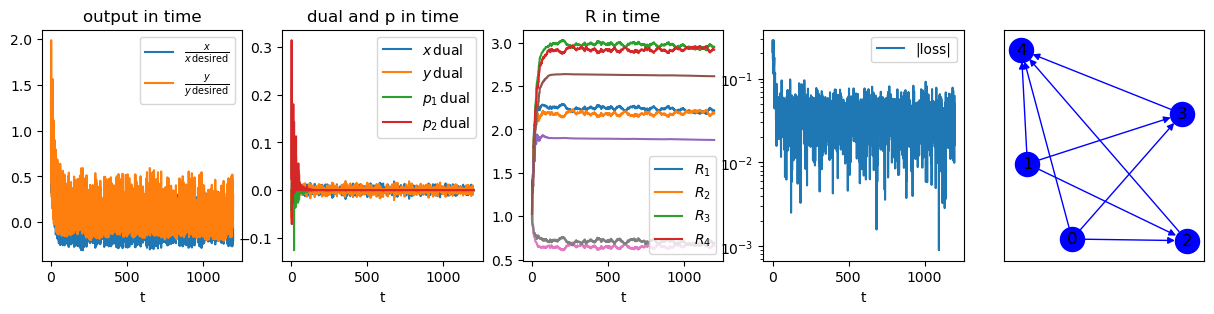

In [15]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

### accuracy

In [16]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(Variabs, State)
else:
    pass

In [17]:
np.mean(np.abs(State.loss_in_t[-1000:]))

0.03472518555785074

## Save sizes to file

In [18]:
# R_propto_deltap = State.R_in_t
# deltaR_propto_deltap = State.R_in_t
# deltaR_propto_Q = State.R_in_t
# deltaR_propto_Power = State.R_in_t

# loss_R_propto_deltap = State.loss_in_t
# loss_deltaR_propto_deltap = State.loss_in_t
# loss_propto_Q = State.loss_in_t
# loss_propto_Power = State.loss_in_t

In [19]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)

In [20]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [21]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

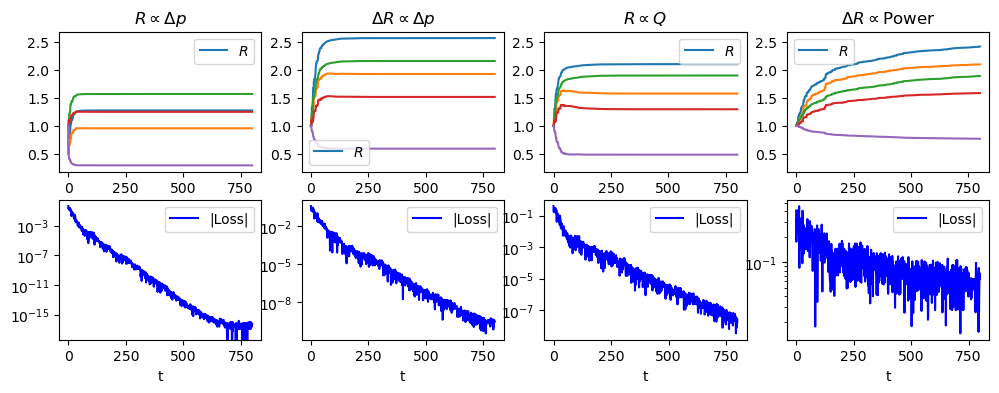

In [22]:
plot_functions.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [23]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [24]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [25]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

In [26]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

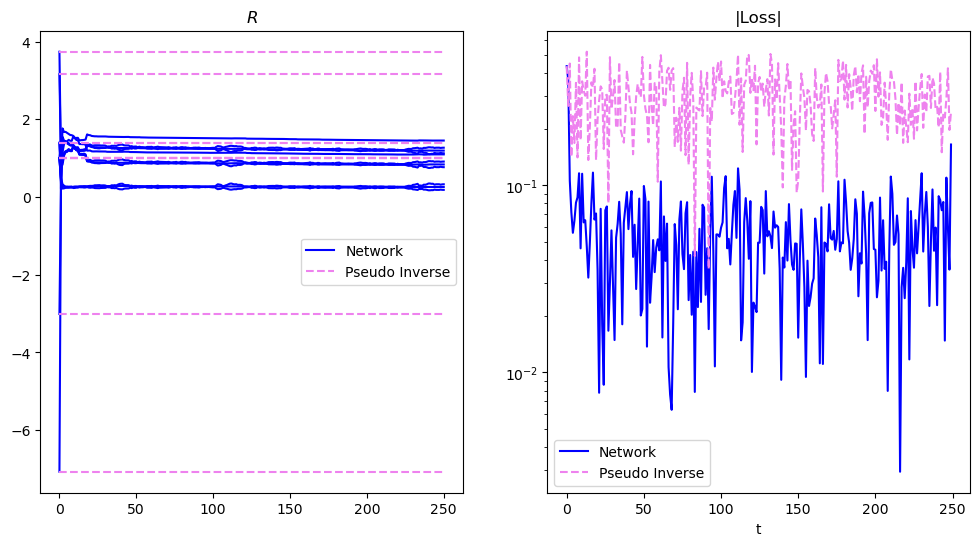

In [27]:
plot_functions.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

## Statistics

### Error

In [28]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.1247693224737152


### Accuracy

In [29]:
accuracy = zeros(np.shape(Variabs.dataset)[0])
for i, datapoint in enumerate(Variabs.dataset):
    State.draw_p_in_and_desired(Variabs, i)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    print('net prediction', np.sum((State.targets_mat - State.output)**2, axis=1))
    accuracy[i] = statistics.calculate_accuracy(State.output, State.target_mat, Variabs.targets[i])

input_drawn [0.74908024 1.90142861]
desired output= [0.49264776 0.37741292]
output measured= [0.42684637 0.44286885]
extraOutput measured= []


AttributeError: 'Network_State' object has no attribute 'targets_mat'

In [ ]:
np.mean(accuracy)

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)